# Thanks to https://www.kaggle.com/siavrez/wavenet-keras and Sergey Bryansky.
# You can take a look at Sergey's kernel [here](https://www.kaggle.com/sggpls/shifted-rfc-pipeline) or [here](https://www.kaggle.com/sggpls/wavenet-with-shifted-rfc-proba). Also, Sergey's [data is here.](https://www.kaggle.com/sggpls/ion-shifted-rfc-proba)

In [1]:
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import random
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
import gc

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# configurations and main hyperparammeters
EPOCHS = 180
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.001
SPLITS = 5

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [3]:
import matplotlib.pyplot as plt

a = np.load("../input/knn-oof/oof_knn_feats.npy")
b = np.load("../input/ion-shifted-rfc-proba/Y_train_proba.npy")
c = np.load("../input/lgb-mlp-oof/oof_pred_lgbm.npy")
d =  np.load("../input/lgb-mlp-oof/oof_pred_mlp.npy")

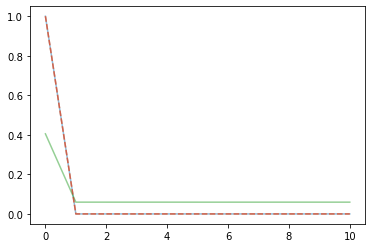

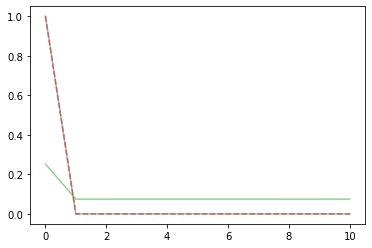

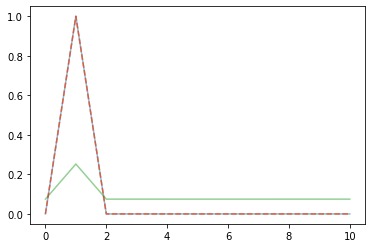

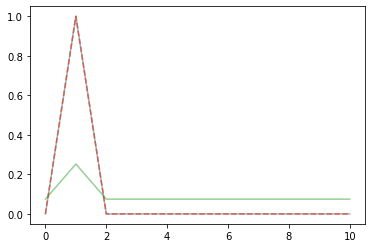

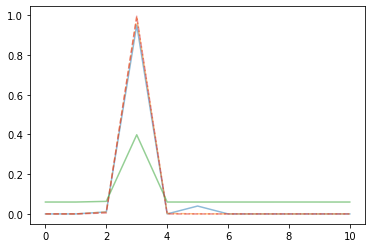

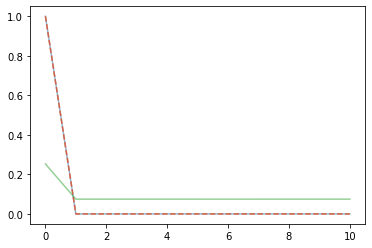

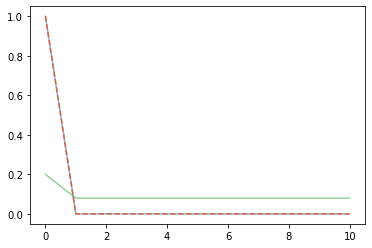

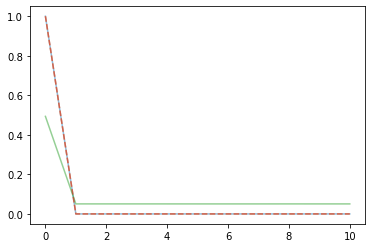

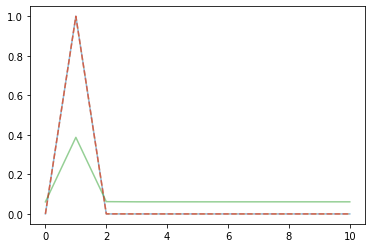

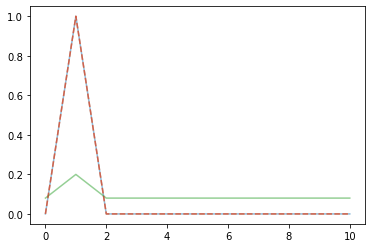

In [4]:
for i in np.random.randint(0, 2000000, size=10):
    plt.plot(a[i, 11:22], alpha=0.5)
    plt.plot(b[i],'--', alpha=0.5)
    plt.plot(c[i], alpha=0.5)
    plt.plot(d[i],'--', alpha=0.5)
    plt.show()

In [5]:
# read data
def read_data():
    train = pd.read_csv('../input/data-without-drift/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('../input/data-without-drift/test_clean.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
    
    Y_train_proba = np.load("../input/ion-shifted-rfc-proba/Y_train_proba.npy")
    Y_test_proba = np.load("../input/ion-shifted-rfc-proba/Y_test_proba.npy")
    for i in range(11):
        train[f"proba_{i}"] = Y_train_proba[:, i]
        test[f"proba_{i}"] = Y_test_proba[:, i]
        
    train_knn_feats = np.load("../input/knn-oof/oof_knn_feats.npy")
    test_knn_feats = np.load("../input/knn-oof/test_knn_feats.npy")
    for i in range(11, 22):
        train[f"knn_feat_{i}"] = train_knn_feats[:, i]
        test[f"knn_feat_{i}"] = test_knn_feats[:, i]

        
    train_pred_lgbm = np.load("../input/lgb-mlp-oof/oof_pred_lgbm.npy")
    test_pred_lgbm = np.load("../input/lgb-mlp-oof/test_pred_lgbm.npy")
    for i in range(11):
        train[f"pred_lgbm_{i}"] = train_pred_lgbm[:, i]
        test[f"pred_lgbm_{i}"] = test_pred_lgbm[:, i]
        
        
    train_pred_mlp = np.load("../input/lgb-mlp-oof/oof_pred_mlp.npy")
    test_pred_mlp = np.load("../input/lgb-mlp-oof/test_pred_mlp.npy")
    for i in range(11):
        train[f"pred_mlp_{i}"] = train_pred_mlp[:, i]
        test[f"pred_mlp_{i}"] = test_pred_mlp[:, i]
        
    return train, test, sub

# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

# model function (very important, you can try different arquitectures to get a better score. I believe that top public leaderboard is a 1D Conv + RNN style)
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 128, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

# function that decrease the learning as epochs increase (i also change this part of the code)
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr

# class to get macro f1 score. This is not entirely necessary but it's fun to check f1 score of each epoch (be carefull, if you use this function early stopping callback will not work)
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis = 2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis = 2).reshape(-1)
        score = f1_score(self.targets, pred, average = 'macro')
        print(f'F1 Macro Score: {score:.5f}')

        
def load(name):
    model = load_model(name, compile=False)
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

# main function to perfrom groupkfold cross validation (we have 1000 vectores of 4000 rows and 8 features (columns)). Going to make 5 groups with this subgroups.
def run_cv_model_by_batch(train, test, splits, batch_col, feats, sample_submission, nn_epochs, nn_batch_size):
    
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train), 11)) # build out of folds matrix with 11 columns, they represent our target variables classes (from 0 to 10)
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)
    # pivot target columns to transform the net to a multiclass classification estructure (you can also leave it in 1 vector with sparsecategoricalcrossentropy loss function)
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
    
    print(train.shape)

    for n_fold, (tr_idx, val_idx, val_orig_idx) in list(enumerate(new_splits))[0:]:
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        print(f'Our training dataset shape is {train_x.shape}')
        print(f'Our validation dataset shape is {valid_x.shape}')

        gc.collect()
        shape_ = (None, train_x.shape[2]) # input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
#         model = Classifier(shape_)
        # using our lr_schedule function
#         cb_lr_schedule = LearningRateScheduler(lr_schedule)
#         model.fit(train_x,train_y,
#                   epochs = nn_epochs,
#                   callbacks = [cb_lr_schedule, MacroF1(model, valid_x, valid_y)], # adding custom evaluation metric for each epoch
#                   batch_size = nn_batch_size,verbose = 2,
#                   validation_data = (valid_x,valid_y))
        
#         model.save(f'model_{n_fold}')
        model = load(f'model_{n_fold}')
    
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
        print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        
        oof_[val_orig_idx,:] += preds_f
        
        te_preds = model.predict(test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS
        
    np.save('oof_wavenet_probs.npy', oof_)
    np.save('test_wavenet_probs.npy', preds_)
    # calculate the oof macro f1_score
    f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
    
    print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    sample_submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
    sample_submission.to_csv('submission_wavenet.csv', index=False, float_format='%.4f')
    
# this function run our entire program
def run_everything():
    
    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')
        
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    display(train.head())
    display(test.head())
    print('Feature Engineering Completed...')
        
   
    print(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started...')
    run_cv_model_by_batch(train, test, SPLITS, 'group', features, sample_submission, EPOCHS, NNBATCHSIZE)
    print('Training completed...')
        
run_everything()

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...


,time,signal,open_channels,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10,knn_feat_11,knn_feat_12,knn_feat_13,knn_feat_14,knn_feat_15,knn_feat_16,knn_feat_17,knn_feat_18,knn_feat_19,knn_feat_20,knn_feat_21,pred_lgbm_0,pred_lgbm_1,pred_lgbm_2,pred_lgbm_3,pred_lgbm_4,pred_lgbm_5,pred_lgbm_6,pred_lgbm_7,pred_lgbm_8,pred_lgbm_9,pred_lgbm_10,pred_mlp_0,pred_mlp_1,pred_mlp_2,pred_mlp_3,pred_mlp_4,pred_mlp_5,pred_mlp_6,pred_mlp_7,pred_mlp_8,pred_mlp_9,pred_mlp_10,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2
0,0.0001,-1.146217,0,0.966731,0.028343,0.004812,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493423,0.05071,0.050681,0.050683,0.050661,0.050615,0.050618,0.050624,0.050686,0.050647,0.050651,1.0,2.938296e-18,2.388695e-29,1.920335e-38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,-1.184806,0.000000,-1.004040,0.000000,-1.299603,1.313814
1,0.0002,-1.184806,0,0.996045,0.003466,0.000426,0.000063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493423,0.05071,0.050681,0.050683,0.050661,0.050615,0.050618,0.050624,0.050686,0.050647,0.050651,1.0,3.691166e-15,2.005665e-24,2.800696e-32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.146217,-1.004040,0.000000,-1.299603,0.000000,-1.304482,1.403764
2,0.0003,-1.004040,0,0.976313,0.018989,0.004677,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493423,0.05071,0.050681,0.050683,0.050661,0.050615,0.050618,0.050624,0.050686,0.050647,0.050651,1.0,8.878112e-17,2.665354e-27,1.145956e-35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.184806,-1.299603,-1.146217,-1.304482,0.000000,-1.098556,1.008097
3,0.0004,-1.299603,0,0.996002,0.003625,0.000326,0.000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493423,0.05071,0.050681,0.050683,0.050661,0.050615,0.050618,0.050624,0.050686,0.050647,0.050651,1.0,9.663467e-15,6.522446e-27,3.244215e-35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.004040,-1.304482,-1.184806,-1.098556,-1.146217,-1.121741,1.688969
4,0.0005,-1.304482,0,0.997465,0.002335,0.000158,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.493423,0.05071,0.050681,0.050683,0.050661,0.050615,0.050618,0.050624,0.050686,0.050647,0.050651,1.0,1.507272e-15,2.932380e-28,4.803275e-37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.299603,-1.098556,-1.004040,-1.121741,-1.184806,-1.079080,1.701674


,time,signal,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10,knn_feat_11,knn_feat_12,knn_feat_13,knn_feat_14,knn_feat_15,knn_feat_16,knn_feat_17,knn_feat_18,knn_feat_19,knn_feat_20,knn_feat_21,pred_lgbm_0,pred_lgbm_1,pred_lgbm_2,pred_lgbm_3,pred_lgbm_4,pred_lgbm_5,pred_lgbm_6,pred_lgbm_7,pred_lgbm_8,pred_lgbm_9,pred_lgbm_10,pred_mlp_0,pred_mlp_1,pred_mlp_2,pred_mlp_3,pred_mlp_4,pred_mlp_5,pred_mlp_6,pred_mlp_7,pred_mlp_8,pred_mlp_9,pred_mlp_10,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2
0,500.000092,-1.101795,0.970969,0.025847,0.002903,0.000281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347863,0.06525,0.06523,0.065233,0.065214,0.065179,0.065189,0.065189,0.065233,0.06521,0.065209,1.0,5.473640e-17,8.068801e-19,1.133429e-31,0.0,0.0,6.182288e-36,0.0,0.0,0.000000e+00,0.000000e+00,0,0.000000,-1.182291,0.000000,-1.186577,0.000000,-1.015220,1.213951
1,500.000214,-1.182291,0.992143,0.007455,0.000335,0.000068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347863,0.06525,0.06523,0.065233,0.065214,0.065179,0.065189,0.065189,0.065233,0.06521,0.065209,1.0,7.500757e-10,7.261570e-21,3.374961e-27,0.0,0.0,5.798947e-24,0.0,0.0,5.415415e-29,2.417263e-21,0,-1.101795,-1.186577,0.000000,-1.015220,0.000000,-1.088015,1.397811
2,500.000305,-1.186577,0.995843,0.003834,0.000271,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347863,0.06525,0.06523,0.065233,0.065214,0.065179,0.065189,0.065189,0.065233,0.06521,0.065209,1.0,1.615100e-16,1.145235e-25,4.627449e-33,0.0,0.0,5.306859e-31,0.0,0.0,0.000000e+00,0.000000e+00,0,-1.182291,-1.015220,-1.101795,-1.088015,0.000000,-1.068027,1.407966
3,500.000397,-1.015220,0.994366,0.004576,0.001022,0.000036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347863,0.06525,0.06523,0.065233,0.065214,0.065179,0.065189,0.065189,0.065233,0.06521,0.065209,1.0,2.230782e-14,7.923887e-18,8.230845e-31,0.0,0.0,1.635286e-26,0.0,0.0,0.000000e+00,0.000000e+00,0,-1.186577,-1.088015,-1.182291,-1.068027,-1.101795,-1.137354,1.030672
4,500.000488,-1.088015,0.994001,0.005714,0.000241,0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.347863,0.06525,0.06523,0.065233,0.065214,0.065179,0.065189,0.065189,0.065233,0.06521,0.065209,1.0,4.720231e-15,1.082418e-17,3.284327e-30,0.0,0.0,2.218207e-27,0.0,0.0,0.000000e+00,0.000000e+00,0,-1.015220,-1.068027,-1.186577,-1.137354,-1.182291,-1.153899,1.183776


Feature Engineering Completed...
Training Wavenet model with 5 folds of GroupKFold Started...
(1250, 4000, 52)
Our training dataset shape is (1000, 4000, 52)
Our validation dataset shape is (250, 4000, 52)
Training fold 1 completed. macro f1 score : 0.94018
Our training dataset shape is (1000, 4000, 52)
Our validation dataset shape is (250, 4000, 52)
Training fold 2 completed. macro f1 score : 0.94152
Our training dataset shape is (1000, 4000, 52)
Our validation dataset shape is (250, 4000, 52)
Training fold 3 completed. macro f1 score : 0.93870
Our training dataset shape is (1000, 4000, 52)
Our validation dataset shape is (250, 4000, 52)
Training fold 4 completed. macro f1 score : 0.93968
Our training dataset shape is (1000, 4000, 52)
Our validation dataset shape is (250, 4000, 52)
Training fold 5 completed. macro f1 score : 0.94035
Training completed. oof macro f1 score : 0.94012
Training completed...


In [6]:
# !kaggle competitions submit -c liverpool-ion-switching -f submission_wavenet.csv -m "crg proba knn lgbm mlp"

In [8]:
old = pd.read_csv('submission_wavenet_ old_best_944.csv')
new = pd.read_csv('submission_wavenet.csv')

In [11]:
(old.open_channels == new.open_channels).mean()

0.998398

In [7]:
# opt = Adam(lr = LR)
# opt = tfa.optimizers.SWA(opt)

